In [6]:
import numpy as np 

In [7]:
#Build the char index that we will use to encode seqs to numbers 
#(this char index was written by Jason Brownlee from Machine Learning Mastery)
char_index = '0abcdefghijklmnopqrstuvwxyz'
char_index +='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
char_index += '123456789'
char_index += '().,-/+=&$?@#!*:;_[]|%⸏{}\"\'' + ' ' +'\\'

char_to_int = dict((c, i) for i, c in enumerate(char_index))
int_to_char = dict((i, c) for i, c in enumerate(char_index))

from keras.preprocessing.sequence import pad_sequences
#function that convert a char seqs to numbers seqs 
#(it does a little more but lets leave it for now)
def encode_sequence_list(seqs, feat_n=0):
    encoded_seqs = []
    for seq in seqs:
        encoded_seq = [char_to_int[c] for c in seq]
        encoded_seqs.append(encoded_seq)
    if(feat_n > 0):
        encoded_seqs.append(np.zeros(feat_n))
    return pad_sequences(encoded_seqs, padding='post')

def decode_sequence_list(seqs):
    decoded_seqs = []
    for seq in seqs:
        decoded_seq = [int_to_char[i] for i in seq]
        decoded_seqs.append(decoded_seq)
    return decoded_seqs
    
# Using the char_index, the encode_sequence_list function
# will turn a string like this EBCA0OXO 
#to an array like this [29 32 27 27  0 42 42 38]

# encode each string seq to an integer array [[1],[5],[67]], [[45],[76],[7]
encoded_seqs = encode_sequence_list(random_sequences)
# mix everything up
np.random.shuffle(encoded_seqs)

In [25]:
df_test = pd.read_csv("ValidationDataConveyor.csv")
df_train = pd.read_csv("TrainingDataConveyor.csv")

In [43]:
type(df_test.values)

numpy.ndarray

In [28]:
#Scale our data using a MinMaxScaler that will scale 
#each number so that it will be between 0 and 1
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaled_seqs = scaler.fit_transform(df_test)
#Create a test and train sets of our data
X_train = scaled_seqs[:2000]
X_test = scaled_seqs[2000:]

In [34]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

input_dim = X_train.shape[1] #features
encoding_dim = 20
hidden_dim = int(encoding_dim / 2)

nb_epoch = 30
batch_size = 128
learning_rate = 0.1

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='relu')(encoder)
decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [35]:
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model_seqs2.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 2000 samples, validate on 444 samples
Epoch 1/30
2000/2000 [==============================] - 1s 397us/step - loss: 0.3914 - accuracy: 0.0000e+00 - val_loss: 0.3249 - val_accuracy: 0.0495
Epoch 2/30
2000/2000 [==============================] - 0s 12us/step - loss: 0.2932 - accuracy: 0.0540 - val_loss: 0.2614 - val_accuracy: 0.1622
Epoch 3/30
2000/2000 [==============================] - 0s 14us/step - loss: 0.2403 - accuracy: 0.1590 - val_loss: 0.2209 - val_accuracy: 0.2950
Epoch 4/30
2000/2000 [==============================] - 0s 14us/step - loss: 0.2045 - accuracy: 0.2050 - val_loss: 0.1912 - val_accuracy: 0.2162


C:\Users\cyk\AppData\Roaming\Python\Python38\site-packages\keras\callbacks\callbacks.py:92: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.323305). Check your callbacks.
  warnings.warn(


Epoch 5/30
2000/2000 [==============================] - 0s 17us/step - loss: 0.1781 - accuracy: 0.1735 - val_loss: 0.1688 - val_accuracy: 0.2207
Epoch 6/30
2000/2000 [==============================] - 0s 13us/step - loss: 0.1584 - accuracy: 0.1870 - val_loss: 0.1517 - val_accuracy: 0.1892
Epoch 7/30
2000/2000 [==============================] - 0s 17us/step - loss: 0.1435 - accuracy: 0.1835 - val_loss: 0.1383 - val_accuracy: 0.1824
Epoch 8/30
2000/2000 [==============================] - 0s 14us/step - loss: 0.1312 - accuracy: 0.1760 - val_loss: 0.1256 - val_accuracy: 0.1712
Epoch 9/30
2000/2000 [==============================] - 0s 12us/step - loss: 0.1190 - accuracy: 0.1655 - val_loss: 0.1139 - val_accuracy: 0.1644
Epoch 10/30
2000/2000 [==============================] - 0s 14us/step - loss: 0.1077 - accuracy: 0.1630 - val_loss: 0.1035 - val_accuracy: 0.1689
Epoch 11/30
2000/2000 [==============================] - 0s 13us/step - loss: 0.0979 - accuracy: 0.2185 - val_loss: 0.0956 - val_

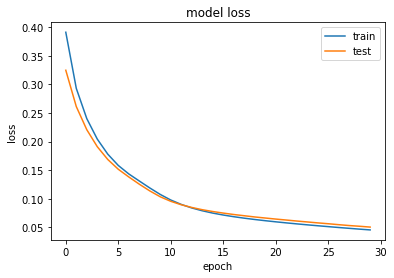

In [36]:
import matplotlib.pyplot as plt
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [37]:
#get the MSE error term
predictions = autoencoder.predict(scaled_seqs)
mse = np.mean(np.power(scaled_seqs - predictions, 2), axis=1)
print('MSE:', np.quantile(mse, 0.9999)) # => the 9999% quatile - only 0.0001% have error score higher than that

MSE: 0.09857319242600582


In [49]:
#scale it
scaled_data = MinMaxScaler().fit_transform(df_test.values)
#predict it
predicted = autoencoder.predict(scaled_data)
#get the error term
mse = np.mean(np.power(scaled_data - predicted, 2), axis=1)
#now add them to our data frame
df_test['MSE'] = mse

In [53]:
mse_threshold = np.quantile(df_test['MSE'], 0.9999)
print(f'MSE 0.9999 threshhold:{mse_threshold}')

df_test['MSE_Outlier'] = 0
df_test.loc[df_test['MSE'] > mse_threshold, 'MSE_Outlier'] = 1

print(f"Num of MSE outlier:{df_test['MSE_Outlier'].sum()}")

df_test[["Timestamp", "MSE_Outlier"]].head()

MSE 0.9999 threshhold:0.09857319242600582
Num of MSE outlier:1


,Timestamp,MSE_Outlier
0,0.000000,0
1,0.084000,0
2,0.139000,0
3,0.182999,0
4,0.247002,0
